<a href="https://colab.research.google.com/github/RoyEdri/RoyEdri-Reinforcement-Learning-TicTacToe/blob/main/Roy_Edri_Project_4_TicTacToe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: TIC-TAC-TOE with RL

In this project, you will delve into the world of reinforcement learning by developing an advanced version of the classic Tic Tac Toe game. You will be responsible for coding the game's logic and employing a variety of reinforcement learning strategies, including Monte Carlo method, Q-learning, Deep Q-Network (DQN), and Double Deep Q-Network (DDQN). Your goal will be to train models that master the game. You will construct the game environment, apply cutting-edge reinforcement learning techniques, and assess how well your models perform.
This hands-on experience is designed to equip you with a solid understanding of reinforcement learning fundamentals and its real-world applications in creating intelligent systems. By the end of the project, you will have practical skills in training AI agents to tackle complex challenges.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
my_path="/content/drive/MyDrive/"

Required Libraries

In [3]:
import pickle
import numpy as np
import random
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Conv1D
from keras.models import load_model
from keras.layers import Dropout
from keras.losses import mean_squared_error

# Tic Tac Toe Environment
This TicTacToe class defines the structure and logic for a customizable Tic Tac Toe game. The class initializes with an optional size parameter (defaulting to 3x3), sets up an empty game board, and tracks the current winner, which is initially set to None. Key methods include print_board to display the current state of the board, available_moves to list possible moves, make_move to update the board with a player's move, and winner to check if a move results in a win. The class also includes utility functions like empty_squares and num_empty_squares to assess the board's status.

***no modifications are required from participants. The class is ready to be used directly in the exercise.***

In [4]:
class TicTacToe:
    def __init__(self, size=3):
        # Initialize the Tic Tac Toe board with given size
        self.size = size
        # Create an empty board using a list
        self.board = [' ' for _ in range(size*size)]
        # Current winner is set to None initially
        self.current_winner = None

    def print_board(self):
        # Print the Tic Tac Toe board
        for row in [self.board[i * self.size:(i + 1) * self.size] for i in range(self.size)]:
            print('| ' + ' | '.join(row) + ' |')

    @staticmethod
    def print_board_nums(size):
        # Print the board with numbers indicating the positions
        number_board = [[str(i) for i in range(j * size, (j + 1) * size)] for j in range(size)]
        for row in number_board:
            print('| ' + ' | '.join(row) + ' |')

    def available_moves(self):
        # Return a list of available moves
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def total_moves(self):
        # Return a list of all moves
        return [i for i, _ in enumerate(self.board)]

    def empty_squares(self):
        # Check if there are empty squares on the board
        return ' ' in self.board

    def num_empty_squares(self):
        # Return the number of empty squares
        return self.board.count(' ')

    def make_move(self, square, letter):
        # Make a move on the board
        if self.board[square] == ' ':
            self.board[square] = letter
            # Check if the current move leads to a win
            if self.winner(square, letter):
                self.current_winner = letter
            return self.board
        else:
            # Print message if the square is invalid
            print("INVALID SQUARE: ",square)

    def winner(self, square, letter):
        # Check if there is a winner after the current move
        row_ind = square // self.size
        row = self.board[row_ind * self.size:(row_ind + 1) * self.size]
        if all([spot == letter for spot in row]):
            return True
        col_ind = square % self.size
        column = [self.board[col_ind + i * self.size] for i in range(self.size)]
        if all([spot == letter for spot in column]):
            return True
        if square % (self.size + 1) == 0:  # diagonal 1
            diagonal1 = [self.board[i] for i in range(0, self.size * self.size, self.size + 1)]
            if all([spot == letter for spot in diagonal1]):
                return True
        if square % (self.size - 1) == 0 and square != 0 and square != self.size * (self.size - 1):  # diagonal 2
            diagonal2 = [self.board[i] for i in range(self.size - 1, self.size * self.size - 1, self.size - 1)]
            if all([spot == letter for spot in diagonal2]):
                return True
        return False

# 1. Monte Carlo

The following TicTacToe MonteCarlo class implements the Monte Carlo learning method to optimize the game strategy for Tic Tac Toe. It is initialized with parameters for the game size, learning rate, discount factor, and exploration rate (epsilon). The class manages a Q-table for storing the value estimates for each state-action pair, and employs an epsilon-greedy strategy for action selection to balance between exploration and exploitation.

Key functionalities include:

* state_to_str(state): Converts the game state to a string key for Q-table referencing.
* select_action(state, moves): Determines the next action using an epsilon-greedy approach. It randomly selects an action with a probability of epsilon for exploration; otherwise, it chooses the action with the highest estimated value from the Q-table for exploitation.
* update_q_table(episode, reward): Updates the Q-table based on the total reward obtained at the end of an episode. This method employs the Monte Carlo approach by updating the Q-values for all unique state-action pairs visited in an episode, applying a learning rate to adjust values towards the observed total reward.
* train(episodes): Conducts multiple episodes of game simulations to train the model. During each episode, the game is played until there are no more moves or a player wins. Rewards are assigned based on the game outcome, and the Q-table is updated with the cumulative reward of the episode.

***no modifications are required from participants. The class is ready to be used directly in the exercise.***

In [5]:
class TicTacToeMonteCarlo:
    def __init__(self, size=3, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.size = size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = {}
        self.game = TicTacToe(size)
        self.player_1 = 'X'
        self.player_2 = 'O'

    def state_to_str(self, state):
        return ''.join(state)

    def select_action(self, state, moves):
        state_str = self.state_to_str(state)
        if np.random.rand() < self.epsilon:
            return random.choice(moves)
        else:
            if state_str not in self.q_table:
                return random.choice(moves)
            filtered_items = [(key, value) for key, value in self.q_table[state_str].items() if key in moves]
            return max(filtered_items, key=lambda item: item[1])[0]

    def update_q_table(self, episode, reward):
        visited_states = set()
        for state, action in episode:
            state_str = self.state_to_str(state)
            if state_str not in visited_states:
                if state_str not in self.q_table:
                    self.q_table[state_str] = {}
                if action not in self.q_table[state_str]:
                    self.q_table[state_str][action] = 0
                self.q_table[state_str][action] += self.learning_rate * (reward - self.q_table[state_str][action])
                visited_states.add(state_str)

    def train(self, episodes):
        for _ in tqdm(range(episodes)):
          game_over = False
          episode = []
          self.game = TicTacToe(self.size)
          current_state = self.game.board.copy()
          total_reward = 0
          letter = self.player_1
          while self.game.empty_squares():
            moves = self.game.available_moves()
            if letter == self.player_2:
              square = random.choice(moves)
            else:
              square = self.select_action(current_state, moves)
            episode.append((current_state, square))
            next_state = self.game.make_move(square, letter)

            if self.game.current_winner:
              if letter == self.player_1:
                reward = 1 # win
              else:
                reward = -1.5 # loose
              game_over = True
              break
            else:
              reward = 0.0001

            total_reward += reward
            current_state = next_state.copy()
            letter = self.player_2 if letter == self.player_1 else self.player_1  # Switch player
          if not game_over:
            reward = 0.5
          total_reward += reward
          self.update_q_table(episode, total_reward)

    def evaluate(self, episodes=100):
        wins = 0
        losses = 0
        draws = 0
        for _ in tqdm(range(episodes)):
            self.game = TicTacToe(self.size)
            current_state = self.game.board.copy()
            letter = self.player_1

            while self.game.empty_squares():
                moves = self.game.available_moves()
                if letter == self.player_2:
                    square = random.choice(moves)  # Random move for the opponent
                else:
                    square = self.select_action(current_state, moves)

                self.game.make_move(square, letter)
                if self.game.current_winner:
                    if letter == self.player_1:
                        wins += 1
                    else:
                        losses += 1
                    break
                letter = self.player_2 if letter == self.player_1 else self.player_1  # Switch player

            if not self.game.current_winner and not self.game.empty_squares():
                draws += 1

        print(f"Evaluation over {episodes} episodes:")
        print(f"Wins: {wins}")
        print(f"Losses: {losses}")
        print(f"Draws: {draws}")

        return wins, losses, draws  # Return results


# 1.a - Set Initial Parameters:


In [6]:
size = 3
learning_rate = 0.001
discount_factor = 0.99
epsilon = 0.1
episodes = 100000

mc = TicTacToeMonteCarlo(size=size, learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon)
mc.train(episodes)
mc.evaluate(episodes=100)

100%|██████████| 100/100 [00:00<00:00, 7960.49it/s]

Evaluation over 100 episodes:
Wins: 54
Losses: 27
Draws: 19


(54, 27, 19)

# 1.b - Modify and Test Each Parameter:
  -  Learning Rate
  -  Discount Factor
  -  Epsilon
  -  Episodes

In [7]:
# Learning Rate: Increase and decrease the learning rate
learning_rates = [0.0001, 0.001, 0.01, 0.1]
for lr in learning_rates:
    print(f"Testing with Learning Rate: {lr}")
    mc = TicTacToeMonteCarlo(size=size, learning_rate=lr, discount_factor=discount_factor, epsilon=epsilon)
    mc.train(episodes)
    mc.evaluate(episodes=100)

Testing with Learning Rate: 0.0001


100%|██████████| 100/100 [00:00<00:00, 7961.85it/s]


Evaluation over 100 episodes:
Wins: 66
Losses: 27
Draws: 7
Testing with Learning Rate: 0.001


100%|██████████| 100/100 [00:00<00:00, 8941.17it/s]


Evaluation over 100 episodes:
Wins: 67
Losses: 24
Draws: 9
Testing with Learning Rate: 0.01


100%|██████████| 100/100 [00:00<00:00, 12521.06it/s]


Evaluation over 100 episodes:
Wins: 79
Losses: 12
Draws: 9
Testing with Learning Rate: 0.1


100%|██████████| 100/100 [00:00<00:00, 14400.05it/s]

Evaluation over 100 episodes:
Wins: 59
Losses: 28
Draws: 13


In [8]:
# Discount Factor: Experiment with higher and lower values close to 1 and 0, respectively.
discount_factors = [0.0, 0.5, 0.99, 1.0]
for df in discount_factors:
    print(f"Testing with Discount Factor: {df}")
    mc = TicTacToeMonteCarlo(size=size, learning_rate=learning_rate, discount_factor=df, epsilon=epsilon)
    mc.train(episodes)
    mc.evaluate(episodes=100)

Testing with Discount Factor: 0.0


100%|██████████| 100/100 [00:00<00:00, 5734.31it/s]


Evaluation over 100 episodes:
Wins: 62
Losses: 16
Draws: 22
Testing with Discount Factor: 0.5


100%|██████████| 100/100 [00:00<00:00, 7943.16it/s]


Evaluation over 100 episodes:
Wins: 62
Losses: 27
Draws: 11
Testing with Discount Factor: 0.99


100%|██████████| 100/100 [00:00<00:00, 8967.55it/s]


Evaluation over 100 episodes:
Wins: 73
Losses: 18
Draws: 9
Testing with Discount Factor: 1.0


100%|██████████| 100/100 [00:00<00:00, 10686.40it/s]

Evaluation over 100 episodes:
Wins: 56
Losses: 23
Draws: 21


In [9]:
# Epsilon: Vary the epsilon value to alter the balance between exploration and exploitation.
epsilons = [0.01, 0.3, 0.5, 0.9]

for ep in epsilons:
    print(f"Testing with Epsilon: {ep}")
    mc = TicTacToeMonteCarlo(size=size, learning_rate=learning_rate, discount_factor=discount_factor, epsilon=ep)
    mc.train(episodes)
    mc.evaluate(episodes=100)

Testing with Epsilon: 0.01


100%|██████████| 100/100 [00:00<00:00, 3821.72it/s]


Evaluation over 100 episodes:
Wins: 54
Losses: 17
Draws: 29
Testing with Epsilon: 0.3


100%|██████████| 100/100 [00:00<00:00, 11956.40it/s]


Evaluation over 100 episodes:
Wins: 71
Losses: 18
Draws: 11
Testing with Epsilon: 0.5


100%|██████████| 100/100 [00:00<00:00, 14268.28it/s]


Evaluation over 100 episodes:
Wins: 69
Losses: 16
Draws: 15
Testing with Epsilon: 0.9


100%|██████████| 100/100 [00:00<00:00, 3443.15it/s]

Evaluation over 100 episodes:
Wins: 69
Losses: 16
Draws: 15


In [10]:
# Episodes: Adjust the number of episodes.
episode_counts = [1000, 10000, 100000, 200000]
for ep_count in episode_counts:
    print(f"Testing with Episodes: {ep_count}")
    mc = TicTacToeMonteCarlo(size=size, learning_rate=learning_rate, discount_factor=discount_factor, epsilon=epsilon)
    mc.train(ep_count)
    mc.evaluate(episodes=100)

Testing with Episodes: 1000


100%|██████████| 100/100 [00:00<00:00, 4058.00it/s]


Evaluation over 100 episodes:
Wins: 67
Losses: 11
Draws: 22
Testing with Episodes: 10000


100%|██████████| 100/100 [00:00<00:00, 7965.18it/s]


Evaluation over 100 episodes:
Wins: 70
Losses: 19
Draws: 11
Testing with Episodes: 100000


100%|██████████| 100/100 [00:00<00:00, 11838.62it/s]


Evaluation over 100 episodes:
Wins: 69
Losses: 16
Draws: 15
Testing with Episodes: 200000


100%|██████████| 100/100 [00:00<00:00, 7673.72it/s]

Evaluation over 100 episodes:
Wins: 65
Losses: 25
Draws: 10


# 1.c


100%|██████████| 100/100 [00:00<00:00, 9862.68it/s]


Evaluation over 100 episodes:
Wins: 70
Losses: 19
Draws: 11


100%|██████████| 100/100 [00:00<00:00, 4792.56it/s]


Evaluation over 100 episodes:
Wins: 70
Losses: 15
Draws: 15


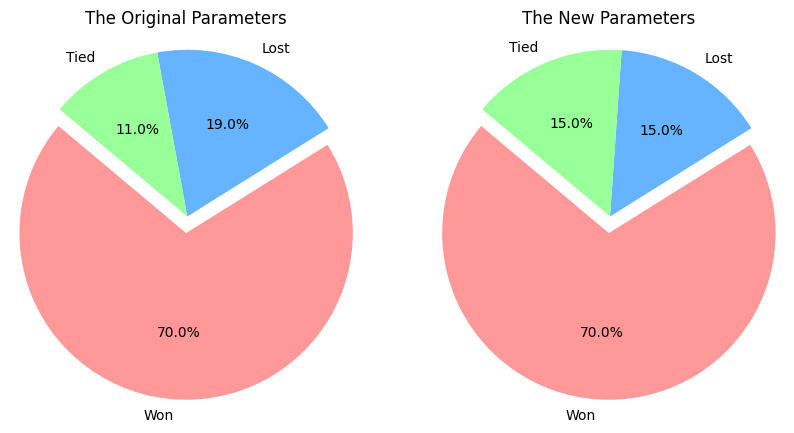

In [32]:
import matplotlib.pyplot as plt

def plot_game_statistics(wins, losses, draws, title, ax):
    labels = ['Won', 'Lost', 'Tied']
    sizes = [wins, losses, draws]
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    explode = (0.1, 0, 0)
    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.axis('equal')
    ax.set_title(title)

# Evaluation with initial parameters
default_learning_rate = 0.001
default_epsilon = 0.1

mc_default = TicTacToeMonteCarlo(size=size, learning_rate=default_learning_rate, discount_factor=discount_factor, epsilon=default_epsilon)
mc_default.train(episodes)
wins_original, losses_original, draws_original = mc_default.evaluate(episodes=100)

# Adjusting epsilon
adjusted_epsilon = 0.5
mc_eps = TicTacToeMonteCarlo(size=size, learning_rate=default_learning_rate, discount_factor=discount_factor, epsilon=adjusted_epsilon)
mc_eps.train(episodes)
wins_new, losses_new, draws_new = mc_eps.evaluate(episodes=100)

# Plotting the two pie charts side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_game_statistics(wins_original, losses_original, draws_original, "The Original Parameters", axes[0])
plot_game_statistics(wins_new, losses_new, draws_new, "The New Parameters", axes[1])

plt.show()


### Game Play
using the Q table updated with MC

In [12]:
size = 3
game_over = True
game = TicTacToe(size)
# game.print_board_nums(game.size)
current_state = game.board.copy()

letter = mc.player_1
while game.empty_squares():
    moves = game.available_moves()
    if letter == mc.player_2:
        square = random.choice(moves)
        print(f"Player 2: {square}")
    else:
        state_str = mc.state_to_str(current_state)
        if state_str in mc.q_table.keys():
          filtered_items = [(key, value) for key, value in mc.q_table[state_str].items() if key in moves]
          square = max(filtered_items, key=lambda item: item[1])[0]
        else:
          square = random.choise(moves)
        print(f"Player 1: {square}")

    next_state = game.make_move(square, letter)
    game.print_board()
    print("__________________________________________________")

    if game.current_winner:
      print(f"Winner is {letter}.")
      game_over = False
      break

    letter = mc.player_2 if letter == mc.player_1 else mc.player_1  # Switch player
if game_over:
  print("its a Tie.")

Player 1: 8
|   |   |   |
|   |   |   |
|   |   | X |
__________________________________________________
Player 2: 7
|   |   |   |
|   |   |   |
|   | O | X |
__________________________________________________
Player 1: 4
|   |   |   |
|   | X |   |
|   | O | X |
__________________________________________________
Player 2: 2
|   |   | O |
|   | X |   |
|   | O | X |
__________________________________________________
Player 1: 5
|   |   | O |
|   | X | X |
|   | O | X |
__________________________________________________
Player 2: 6
|   |   | O |
|   | X | X |
| O | O | X |
__________________________________________________
Player 1: 0
| X |   | O |
|   | X | X |
| O | O | X |
__________________________________________________
Winner is X.


# 2. Q Learning
Train your player using Q-learning. Update the Q-values using the Bellman equation.

Bellman eqution used to update the q values.

*Q(s, a) = Q(s, a) + &#945;[ r + &#947; max<sub>a`</sub>Q(s', a') - Q(s, a)]*

An Epsilon-Greedy strategy is employed to choose subsequent actions.

# Epsilon-Greedy Action Selection in Q-Learning
1. state_to_str(state): This function is designed to convert the game's state into a string, which serves as a dictionary key. It takes the state (likely a list or array) and concatenates all its elements into a single string. This string representation of the state is essential for storing and retrieving corresponding Q-values in the Q-table efficiently.
2. select_action(state, moves, epsilon): This function implements the epsilon-greedy policy to select the next action. It first converts the current state into a string using the state_to_str function. The action selection process then follows two paths based on a random number compared to the epsilon threshold:
Exploration: With a probability of epsilon, it selects a random action

  *   Exploration: With a probability of epsilon, it selects a random action from the list of available moves. This randomness introduces necessary exploration, allowing the algorithm to discover new strategies.
  * Exploitation: If the random number is above the epsilon threshold, the function proceeds to exploit known information. It checks if the state string exists in the Q-table. If not, a random action is chosen since no learned values exist. If the state is known, it filters the Q-table entries for that state to include only those actions that are available (moves). It then selects the action with the highest Q-value among these filtered entries, enabling the algorithm to use the best-known strategy based on past learning.

In [13]:
# Function to convert the state to a string for dictionary key
def state_to_str(state):
    return ''.join(state)

# Function to select action based on epsilon-greedy policy
def select_action(state, moves, epsilon):
    state_str = state_to_str(state)
    # Exploration: choose a random action with probability epsilon
    if np.random.rand() < epsilon:
        return random.choice(moves)
    else:
        # Exploitation: choose the action with the highest Q-value
        if state_str not in q_table:
            return random.choice(moves)
        filtered_items = [(key, value) for key, value in q_table[state_str].items() if key in moves]
        return max(filtered_items, key=lambda item: item[1])[0]

# 2.a: Complete the missing parts in the function
last line.

In [14]:
# update Q-table
def update_q_table(state, action, reward, next_state, moves, learning_rate, discount_factor):
    state_str = state_to_str(state)
    next_state_str = state_to_str(next_state)

    # Initialize Q-values for new states
    if state_str not in q_table:
        q_table[state_str] = {action: 0 for action in game.total_moves()}

    if next_state_str not in q_table:
        q_table[next_state_str] = {action: 0 for action in game.total_moves()}

    # The maximum Q-value for the next state
    max_next_q_value = max(q_table[next_state_str].values())

    # Update Q-value for the current state-action pair using the Bellman equation
    q_table[state_str][action] += learning_rate * (reward + discount_factor * max_next_q_value - q_table[state_str][action])

#### Training the agent with Q-learning

In [15]:
def train(episodes, epsilon, epsilon_min, epsilon_decay):
    number_of_agent_actions, number_of_random_actions, game_result, epsilon_convergence = [], [], [], []
    # Iterate over the episodes
    for e in tqdm(range(episodes)):
        agent_action, random_action = 0, 0
        result = ''
        game = TicTacToe(size)
        current_state = game.board.copy()  # Copy the current state of the game

        letter = player_1  # Start with player 1
        # Keep playing until the game is over
        while game.empty_squares():
            moves = game.available_moves()  # Get available moves
            # Select a move for the current player
            if letter == player_2:
                random_action += 1
                square = random.choice(moves)  # Random move for player 2
            else:
                agent_action += 1
                square = select_action(current_state, moves, epsilon)  # Use Q-learning to select move for player 1

            next_state = game.make_move(square, letter)  # Make the move and get the next state

            # Check if there is a winner
            if game.current_winner:
                if letter == player_1:
                    reward = win_reward
                    result = 'win' # Player 1 wins
                else:
                    reward = lose_reward
                    result = 'loss'  # Player 2 wins
                break
            elif not game.empty_squares(): # If the game ends in a tie
              reward = tie_reward
              result = 'tie' # Tie reward
            else:
                reward = step_reward  # Small reward for continuing the game

            # Update the Q-table based on the current state, action, reward, and next state
            update_q_table(current_state, square, reward, next_state, moves, learning_rate, discount_factor)

            current_state = next_state.copy()  # Update the current state
            letter = player_2 if letter == player_1 else player_1  # Switch players
        epsilon_convergence.append(epsilon)
        if epsilon > epsilon_min:
          epsilon *= epsilon_decay
        number_of_agent_actions.append(agent_action)
        number_of_random_actions.append(random_action)
        game_result.append(result)
    return number_of_agent_actions, number_of_random_actions, game_result, epsilon_convergence

# 2.b-f: Defining Parameter and Training/Updateing Q table

In [16]:
size = 3 # define the size of grid for the game
learning_rate = 0.001 # determining the weight of the new information
discount_factor = 0.99 # balancing immediate and future reward
epsilon = 1 # balancing between exploration and exploitation for greedy strategy
win_reward = 1 # reward for the action the end up in winning
lose_reward = 0 # reward for the action that end up in loss
tie_reward = 0 # reward for the action if it makes the game tie
step_reward = 0.0001 # Small reward for continuing the game, actions that do not end up in win/lose/tie
episodes = 1000000 # number of episode (games) to play for training
epsilon_decay = 0.995  # Decay rate for epsilon
epsilon_min = 0.01

''' Q table to maintain the q values for state,actions
    {'state': {0: q-values, 1: q_values......n: q-value}}  '''
q_table = {}

player_1 = 'X' # Agent
player_2 = 'O' # Random Player
game = TicTacToe(size)

number_of_agent_actions, number_of_random_actions, episode_results, epsilon_convergence = train(episodes, epsilon, epsilon_min, epsilon_decay)

100%|██████████| 1000000/1000000 [01:59<00:00, 8350.50it/s]


In [17]:
#  2.b :
learning_rate = 0.1

number_of_agent_actions, number_of_random_actions, new_episode_results, epsilon_convergence = train(episodes, epsilon, epsilon_min, epsilon_decay)


100%|██████████| 1000000/1000000 [02:22<00:00, 7015.83it/s]


**b:**

Changing the learning rate to 0.1 allows the agent to learn faster by giving more weight to new information, leading to quicker convergence. However, it may reduce stability, causing the agent's learning to fluctuate more and potentially not settle on an optimal policy.

**c:**

Setting the discount factor to 0.9 prioritizes future rewards, promoting long-term strategies. A factor of 0.5 focuses on immediate rewards, leading to more short-term actions

**d:**

Setting epsilon to 1 results in pure exploration, causing the agent to always select random actions, which prevents it from exploiting learned strategies.

**e:**

More training episodes provide the agent with extensive experience, leading to better policy refinement, improved stability, and more optimal performance in diverse game scenarios.

**f:**

Changing the tie_reward to a negative value forces the agent to avoid ties and take riskier actions for a win, potentially increasing both wins and losses.

In [18]:
learning_rate = 0.001

number_of_agent_actions, number_of_random_actions, new_episode_results, epsilon_convergence = train(episodes, epsilon, epsilon_min, epsilon_decay)


100%|██████████| 1000000/1000000 [02:05<00:00, 7953.32it/s]


In [19]:
print(f"Number of states after training in the Q table: {len(q_table.keys())}")

Number of states after training in the Q table: 3453


### Storing the trained Q table

In [20]:
path_to_store = "/content/drive/MyDrive/Colab Notebooks/Projects/Trained models"

file_name = "size_5_q_learning_table_" + str(episodes) + "ep.pkl"

with open(path_to_store+file_name, 'wb') as f:
        pickle.dump(q_table, f)

### Storing the train stats to CSV

In [21]:
import pandas as pd
store = pd.DataFrame({'#agent actions': number_of_agent_actions, '#computer actions': number_of_random_actions, 'epsilon': epsilon_convergence, 'result': episode_results})
store.to_csv(path_to_store+"q_learning_1000000ep.csv")

### Plotting training stats

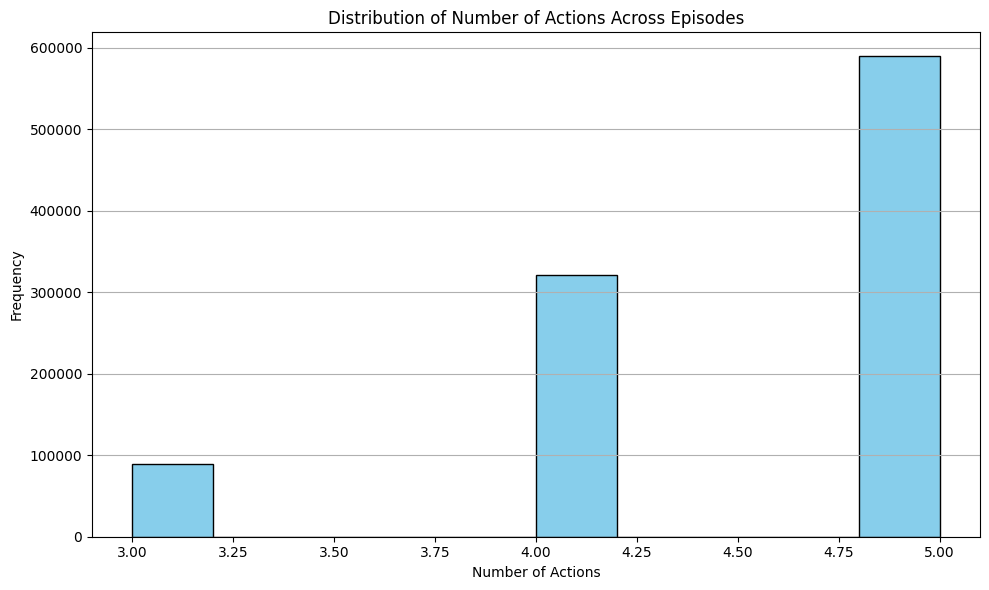

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(number_of_agent_actions, bins=10, color='skyblue', edgecolor='black')  # Adjust bins as needed for the desired level of granularity

# Add labels and title
plt.xlabel('Number of Actions')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Actions Across Episodes')

# Show plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Game Play
Player 1 plays randomly and Player 2 chooses the action based on the Q table.

In [23]:
# if you want to use pre-trained Q table set it to True
pre_trained_q_table = False

if pre_trained_q_table:
  stored_path = my_path
  file_name = "size_5_q_learning_table_10000000ep.pkl"

  with open(stored_path + file_name, 'rb') as f:
        q_table = pickle.load(f)

number_of_games = 100 # number of games you want to play

''' Store the stats of the game play (for player 1: Agent)'''
total_wins, total_losses, total_ties = 0, 0, 0

for g in range(number_of_games):
  print(f"Game: {g}")

  game = TicTacToe(size)  # Initialize the game
  current_state = game.board.copy()

  letter = player_1  # Start with player 1
  while game.empty_squares():  # Continue playing until the board is full
      moves = game.available_moves()  # Get available moves
      if letter == player_2:
          # Player 2 (random player) selects a random move
          square = random.choice(moves)
          print(f"Player 2: {square}")
      else:
          state_str = state_to_str(current_state)
          # Player 1 (agent) selects the move with the highest Q-value based on the current state
          if state_str in q_table.keys():
              filtered_items = [(key, value) for key, value in q_table[state_str].items() if key in moves]
              square = max(filtered_items, key=lambda item: item[1])[0]
          else:
              square = random.choice(moves)  # If the state is not in Q-table, select a random move
          print(f"Player 1: {square}")

      next_state = game.make_move(square, letter)
      game.print_board()
      print("__________________________________________________")

      if game.current_winner:
        if letter == player_1:
          total_wins += 1
          print("Winner is the Agent.")
        else:
          total_losses += 1
          print("Winner is the Random Player")
        break
      elif not game.empty_squares():
        total_ties += 1
        print("It's a Tie.")

      letter = player_2 if letter == player_1 else player_1  # Switch players for the next move


Game: 0
Player 1: 3
|   |   |   |
| X |   |   |
|   |   |   |
__________________________________________________
Player 2: 6
|   |   |   |
| X |   |   |
| O |   |   |
__________________________________________________
Player 1: 0
| X |   |   |
| X |   |   |
| O |   |   |
__________________________________________________
Player 2: 4
| X |   |   |
| X | O |   |
| O |   |   |
__________________________________________________
Player 1: 2
| X |   | X |
| X | O |   |
| O |   |   |
__________________________________________________
Player 2: 7
| X |   | X |
| X | O |   |
| O | O |   |
__________________________________________________
Player 1: 1
| X | X | X |
| X | O |   |
| O | O |   |
__________________________________________________
Winner is the Agent.
Game: 1
Player 1: 3
|   |   |   |
| X |   |   |
|   |   |   |
__________________________________________________
Player 2: 2
|   |   | O |
| X |   |   |
|   |   |   |
__________________________________________________
Player 1: 0
| X | 

#### Played Game Stats

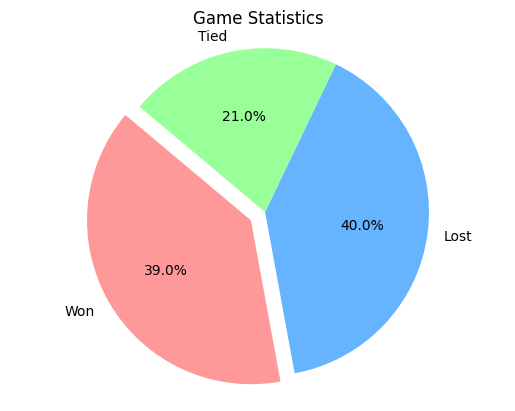

In [24]:
labels = ['Won', 'Lost', 'Tied']
sizes = [total_wins, total_losses, total_ties]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)  # explode 1st slice

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Game Statistics')
plt.savefig(my_path +"game_stats_q_learning.jpg")
plt.show()

# 3. DQN & DDQN
## DQN (Deep Q-Network):
* In DQN, a target network is employed to determine the best action for the next state from the current state during the game. This separate model, the target network, mirrors the architecture of the main network but with periodically updated weights.
* Once the best action is selected by the target network, its Q-value is estimated using the same target network, not the main network. This approach aims to stabilize training by reducing the frequency of policy changes, as the target network's weights are updated less often than those of the main network.
* However, using the same network to both select and evaluate an action can sometimes lead to overestimations of Q-values. This is due to positive biases inherent in the bootstrapping methods where the maximum estimated returns are used for updates. In a game context, such overestimations can lead the learning process to favor certain strategies that might not be as effective as predicted, potentially affecting overall strategy development in gameplay.

## DDQN (Double Deep Q-Network):

* DDQN modifies the DQN approach by splitting the role of action selection and Q-value estimation between two networks. In this setup, the main network is used to choose the best action from the next state.
* However, unlike DQN, the Q-value of this action is evaluated using the target network. This cross-evaluation helps in mitigating the overestimation issue seen in DQN.
* By decoupling the selection and evaluation of actions, DDQN provides a more conservative estimate of Q-values, enhancing the accuracy and stability of training. In the context of Tic Tac Toe, this means DDQN can more reliably evaluate the potential future benefits of moves, leading to more strategic decision-making and potentially stronger gameplay over time.

# 3.a:
- In Q-learning, a neural network is used to approximate Q-values instead of a traditional Q-table. This is particularly useful in large state spaces where maintaining a Q-table is not feasible.
- **Advantages**:
  - **Scalability**: Neural networks handle large state spaces efficiently.
  - **Generalization**: They generalize learning across similar states, improving performance.
  - **Flexibility**: Various architectures and optimization techniques can be applied to improve learning.
- **Disadvantages**:
  - **Training Stability**: Neural networks can be harder to train, especially with sparse rewards or large state spaces.
  - **Overestimation Bias**: Using the same network for action selection and value estimation may lead to overestimated Q-values.


In [25]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=32):
        self.state_size = state_size  # Size of the state space
        self.action_size = action_size  # Number of possible actions
        self.learning_rate = learning_rate  # Learning rate for the neural network
        self.gamma = gamma  # Discount factor for future rewards
        self.epsilon = epsilon  # Exploration rate for epsilon-greedy strategy
        self.epsilon_decay = epsilon_decay  # Decay rate for epsilon
        self.epsilon_min = epsilon_min  # Minimum exploration rate
        self.batch_size = batch_size  # Batch size for training
        self.model = self._build_model()  # Initialize the neural network model
        self.target_model = self._build_model()  # Initialize the target model for fixed Q-targets
        self.replay_memory = deque(maxlen=2000)  # Initialize replay memory

    def _build_model(self):
        # Build the neural network model
        model = Sequential()
        model.add(Dense(48, input_dim=self.state_size, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(24, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=mean_squared_error, optimizer='adam')  # Use mse loss and Adam optimizer
        return model

    def act(self, state, moves):
        # Choose an action based on epsilon-greedy strategy
        if np.random.rand() <= self.epsilon:
            return random.choice(moves)  # Explore: choose a random action
        q_values = self.model.predict(state, verbose=None)  # Exploit: choose the action with highest Q-value
        valid_move_indices = [(i, q_values[0][i]) for i in moves]
        max_valid_move_index, _ = max(valid_move_indices, key=lambda x: x[1])
        return max_valid_move_index

    def remember(self, state, action, reward, next_state, done):
        # Store the experience in replay memory
        self.replay_memory.append((state, action, reward, next_state, done))

    def replay(self, episode, algorithm='DQN'):
        # Train the neural network using experience replay
        if len(self.replay_memory) < self.batch_size:
            return

        minibatch = random.sample(self.replay_memory, self.batch_size)  # Sample a minibatch from replay memory

        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                # Calculate the target value for the Bellman equation
                if algorithm == 'DQN':
                    target = reward + self.gamma * np.amax(self.target_model.predict(next_state, verbose=None)[0])
                else:  # Double DQN (DDQN)
                    next_action = np.argmax(self.model.predict(next_state, verbose=None)[0])
                    target = reward + self.gamma * self.target_model.predict(next_state, verbose=None)[0][next_action]
            target_f = self.model.predict(state, verbose=None)
            target_f[0][action] = target
            states.append(state[0])
            targets.append(target_f[0])

        # Train the model on the minibatch
        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

        # Update the target model periodically
        if episode % 10 == 0:
            self.update_target_model()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return self.epsilon

    def update_target_model(self):
        # Update the weights of the target model to match the current model
        self.target_model.set_weights(self.model.get_weights())

#### Training the DQN model

In [26]:
REWARDS = {'win': 1, 'lose': -10, 'tie': 0.5, 'step': 0.002}
NUM_EPISODES = 100
size = 3  # Assuming a 3x3 tic-tac-toe board
state_size = size * size  # Number of cells on the game board
action_size = state_size  # Number of possible actions, total cells on the game board
learning_rate = 0.01 # Learning rate for the agent
gamma = 0.95 # Discount factor for future rewards
epsilon = 1 # Initial value of epsilon for epsilon-greedy exploration
epsilon_decay = 0.995  # Decay rate for epsilon
epsilon_min = 0.01 # Minimum value of epsilon to ensure some level of exploration
batch_size = 32
algorithm = 'DQN' # choose 'DQN or 'DDQN'
player_1 = 'X'
player_2 = 'O'
agent = DQNAgent(state_size, action_size)

def reshape_state(state): # [[0,1,0,0,0,0,-1,0,0]] for model
  reshaped_state = [0 if cell == ' ' else 1 if cell == 'X' else -1 for cell in state]
  reshaped_state = np.array(reshaped_state)
  return reshaped_state

# Loop through episodes for training
number_of_agent_actions, number_of_random_actions, episode_results, epsilon_convergence = [], [], [], []
for episode in tqdm(range(NUM_EPISODES)):
    game = TicTacToe(size)  # Initialize the TicTacToe game
    done = False  # Indicates if terminal state is reached
    current_state = game.board.copy()  # Copy the initial state of the board
    letter = player_1  # Set the mark for the first player (player 1)
    agent_actions, random_actions = 0, 0
    result = ''
    while game.empty_squares():  # While there are empty squares on the board
        reshaped_current_state = reshape_state(current_state)  # Reshape the state representation
        reshaped_current_state = reshaped_current_state.reshape(1, -1)  # Reshape for compatibility with the model
        moves = game.available_moves()  # Get available moves

        if letter == player_2:  # If it's player 2's turn
            random_actions += 1
            square = random.choice(moves)  # Choose a random move
        else:
            agent_actions += 1
            square = agent.act(reshaped_current_state, moves)  # Choose a move using the agent
            # print(square)

        next_state = game.make_move(square, letter)  # Make the chosen move and get the next state
        reshaped_next_state = reshape_state(next_state)  # Reshape the next state
        reshaped_next_state = reshaped_next_state.reshape(1, -1)  # Reshape for compatibility with the model
        # print(reshaped_next_state)
        # print("-----------------------------------------------------------------------")

        if game.current_winner:  # If there is a winner
            if letter == player_1:  # If player 1 wins
                reward = REWARDS['win']
                result = 'win'  # Assign win reward
            else:
                result = 'loss'
                reward = REWARDS['lose']  # Assign lose reward
            done = True  # Mark episode as done
        else:
            reward = REWARDS['step']  # Assign step reward
            last_state = reshaped_current_state  # Store the last state

        # Store the experience tuple (state, action, reward, next_state, done) in the agent's memory
        agent.remember(reshaped_current_state, square, reward, reshaped_next_state, done)

        # Replay experience to train the agent
        epsilon = agent.replay(episode, 'DQN')

        current_state = next_state.copy()  # Update the current state
        letter = player_2 if letter == player_1 else player_1  # Switch player

    if not done:  # If the episode was not terminated (tied)
        result = 'tie'
        reward = REWARDS['tie']  # Assign tie reward
        agent.remember(last_state, square, reward, reshaped_next_state, done)  # Store the last state
        agent.replay(episode, 'DQN')  # Log the last state that was a tie
    epsilon_convergence.append(epsilon)
    episode_results.append(result)
    number_of_agent_actions.append(agent_actions)
    number_of_random_actions.append(random_actions)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
100%|██████████| 100/100 [1:24:22<00:00, 50.63s/it]


#### save the DQN model

In [27]:
# target model is updated after every 10 episodes, weight from the 'model' is copied to target_model
path_to_store = "/content/drive/MyDrive/Colab Notebooks/Projects/Trained models"
model_name = "ddqn_" + str(NUM_EPISODES) + "ep.h5"
agent.target_model.save(path_to_store + model_name) # change the path for your prefered location

### storing game states in csv

In [28]:
import pandas as pd
my_model_path = "/content/drive/MyDrive/Colab Notebooks/Projects/Trained models"
store = pd.DataFrame({'#agent actions': number_of_agent_actions, '#computer actions': number_of_random_actions, 'result': episode_results})
store.to_csv(my_model_path+"dqn__100ep.csv")


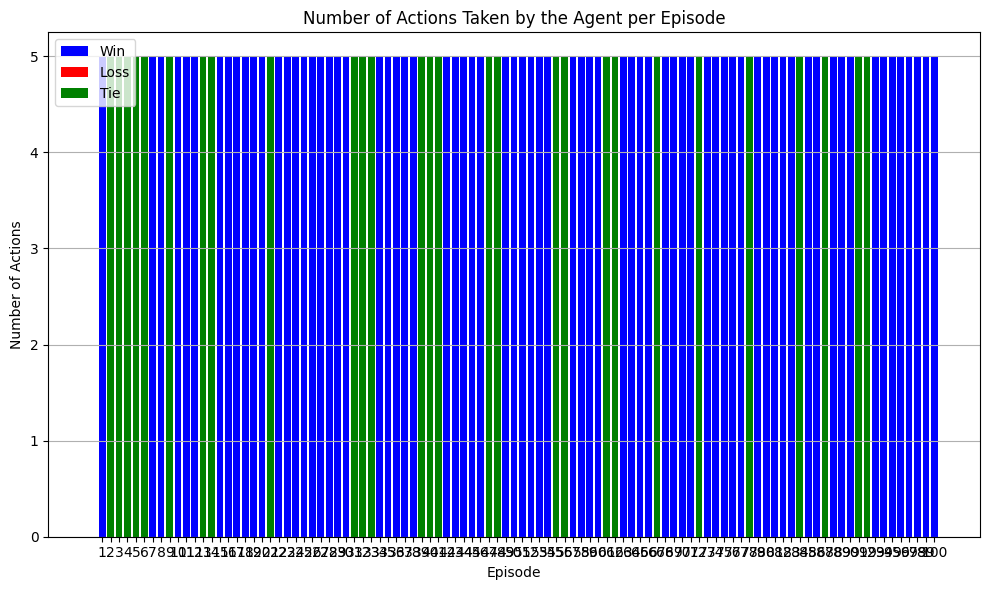

In [29]:
import matplotlib.pyplot as plt

# Mapping status to color
status_color_map = {'win': 'blue', 'loss': 'red', 'tie': 'green'}

# Plotting the bar graph
plt.figure(figsize=(10, 6))
for i in range(len(number_of_agent_actions)):
    plt.bar(i + 1, number_of_agent_actions[i], color=status_color_map[episode_results[i]])

# Adding labels and title
plt.xlabel('Episode')
plt.ylabel('Number of Actions')
plt.title('Number of Actions Taken by the Agent per Episode')

# Adding legend for status colors
for status, color in status_color_map.items():
    plt.bar(0, 0, color=color, label=status.capitalize())  # Dummy bar for legend
plt.legend()

# Show plot
plt.grid(axis='y')
plt.xticks(range(1, len(number_of_agent_actions) + 1))
plt.tight_layout()
plt.savefig(my_model_path+"dqn_train_stat.jpg")
plt.show()

#### Game Play with DQN or DDQN model

In [30]:
use_pre_trained_model = True
if use_pre_trained_model:
  stored_path = "/content/drive/MyDrive/Colab Notebooks/Projects/Trained models"
  model_name = "ddqn_100ep.h5"
  model = load_model(stored_path + model_name)

number_of_games = 10 # number of games you want to play

''' Store the stats of the game play (for player 1: Agent)'''
total_wins, total_losses, total_ties = 0, 0, 0

for g in range(number_of_games):
  print(f"Game: {g}")
  game = TicTacToe(size)
  current_state = game.board.copy()
  letter = player_1
  done = False
  while game.empty_squares():
    reshaped_current_state = reshape_state(current_state) # reshaping to (3,3), ' '->0, 'X'->1, 'O'->-1
    reshaped_current_state = reshaped_current_state.reshape(1, -1)
    moves = game.available_moves()
    if letter == player_1:
      print(f"Player 2: {square}")
      square = random.choice(moves)
    else:
      print(f"Player 1: {square}")
      q_values = model.predict(reshaped_current_state, verbose=None)
      valid_move_indices = [(i, q_values[0][i]) for i in moves]
      square, max_valid_move_value = max(valid_move_indices, key=lambda x: x[1])
    next_state = game.make_move(square, letter)
    game.print_board()
    print("________________________________________________________________________")
    if game.current_winner:
        if letter == player_1:
          total_wins += 1
          print("Winner is the Agent.")
        else:
          total_losses += 1
          print("Winner is the Random Player")
        break
    elif not game.empty_squares():
        total_ties += 1
        print("It's a Tie.")
    letter = player_2 if letter == player_1 else player_1  # Switch player


Game: 0
Player 2: 6
| X |   |   |
|   |   |   |
|   |   |   |
________________________________________________________________________
Player 1: 0
| X |   |   |
|   |   |   |
|   |   | O |
________________________________________________________________________
Player 2: 8
| X |   |   |
|   |   |   |
|   | X | O |
________________________________________________________________________
Player 1: 7
| X |   | O |
|   |   |   |
|   | X | O |
________________________________________________________________________
Player 2: 2
| X |   | O |
|   |   | X |
|   | X | O |
________________________________________________________________________
Player 1: 5
| X |   | O |
|   | O | X |
|   | X | O |
________________________________________________________________________
Player 2: 4
| X |   | O |
|   | O | X |
| X | X | O |
________________________________________________________________________
Player 1: 6
| X |   | O |
| O | O | X |
| X | X | O |
_________________________________________________

### Plotting game play states

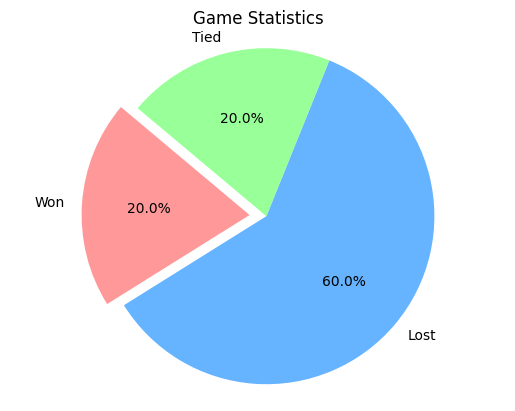

In [31]:
labels = ['Won', 'Lost', 'Tied']
sizes = [total_wins, total_losses, total_ties]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)  # explode 1st slice

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Game Statistics')
plt.show()